In [1]:
import pandas as pd
from pandas_ods_reader import read_ods
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
import skopt

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score

dados= pd.read_csv("raw_data\Anatel.csv")

linhas= dados.index
colunas= dados.columns

Data_Filter = dados.copy()

Data_Filter = Data_Filter[ dados["ANO_BASE"] > 2016]
Data_Filter = Data_Filter[ Data_Filter["E1"] == 1]
Data_Filter = Data_Filter[ Data_Filter["E7"] == 1]
Data_Filter = Data_Filter[ Data_Filter["F3"] == 1]
Data_Filter = Data_Filter[ Data_Filter["A1_1"] == 1]


Data_Filter["ESTADO"] = Data_Filter["ESTADO"].astype('category').cat.codes
Data_Filter["OPERADORA"] = Data_Filter["OPERADORA"].astype('category').cat.codes
Data_Filter.drop("Q2", inplace= True, axis = 1)
Data_Filter.drop("Q2_1", inplace= True, axis = 1)
Data_Filter.drop("Q2_2", inplace= True, axis = 1)
Data_Filter.drop("Q3", inplace= True, axis = 1)
Data_Filter.drop("Q4", inplace= True, axis = 1)
Data_Filter.drop("Q7a", inplace= True, axis = 1)
Data_Filter.drop("A1_1", inplace= True, axis = 1)
Data_Filter.drop("A1_4", inplace= True, axis = 1)
Data_Filter.drop("A4", inplace= True, axis = 1)
Data_Filter.drop("IDTNS", inplace= True, axis = 1)
Data_Filter.drop("G1", inplace= True, axis = 1)
Data_Filter.drop("G2_1", inplace= True, axis = 1)
Data_Filter.drop("G2_2", inplace= True, axis = 1)
Data_Filter.drop("G2_3", inplace= True, axis = 1)
Data_Filter.drop("E1", inplace= True, axis = 1)
Data_Filter.drop("E4", inplace= True, axis = 1)
Data_Filter.drop("E6", inplace= True, axis = 1)
Data_Filter.drop("E7", inplace= True, axis = 1)
Data_Filter.drop("F2_1", inplace= True, axis = 1)
Data_Filter.drop("F2_2", inplace= True, axis = 1)
Data_Filter.drop("F2_3", inplace= True, axis = 1)
Data_Filter.drop("F3", inplace= True, axis = 1)
Data_Filter.drop("I1", inplace= True, axis = 1)
Data_Filter.drop("PESO", inplace= True, axis = 1)
Data_Filter.drop("Q1", inplace= True, axis = 1)
Data_Filter.drop("Q6", inplace= True, axis = 1)
Data_Filter.drop("H3", inplace= True, axis = 1)
Data_Filter.drop("COD_IBGE", inplace= True, axis = 1)
Data_Filter.drop("H2a", inplace= True, axis = 1)
Data_Filter.drop("I2", inplace= True, axis = 1)
Data_Filter.drop("TIPO", inplace= True, axis = 1)
Data_Filter.drop("DATA", inplace= True, axis = 1)
Data_Filter.drop("H0", inplace= True, axis = 1)





Data_Filter["A1_2"] = Data_Filter["A1_2"].replace(2,1)
Data_Filter["A1_3"] = Data_Filter["A1_3"].replace(3,1)
Data_Filter["A1_2"] = Data_Filter["A1_2"].fillna(2)
Data_Filter["A1_3"] = Data_Filter["A1_3"].fillna(2)

Data_Filter.loc[Data_Filter.J1 >= 7, "J1"] = "SATISFEITO"
Data_Filter.loc[Data_Filter.J1 != "SATISFEITO", "J1"] = "INSATISFEITO"

Data_Filter["J1"] = Data_Filter["J1"].replace("SATISFEITO",1)
Data_Filter["J1"] = Data_Filter["J1"].replace("INSATISFEITO",0)


def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel("Taxa de Falsos Positivos")
    plt.ylabel("Taxa de Verdadeiros Positivos")

C:\Users\Usuario\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (54) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Split

In [2]:


Dados_Y = Data_Filter["J1"].copy()
Dados_X = Data_Filter.copy()
Dados_X.drop("J1", inplace= True, axis = 1)

X_train, X_test, y_train, y_test = train_test_split(Dados_X, Dados_Y, test_size=0.3,random_state=109) # 70% training and 30% test


## Indicadores de Precisão 

- Previsão: Acurácia das Previsões positivas;

precisão = (TP/(TP+FP))

- Revocação (Recall): Taxa de Instâncias positivas que são identificadas pelo classificador; 

revocação = (TP/(TP+FN))
            
|          |     0       |     1      |
|----------|-------------|------------|
|     0    |     TN    |     FP    |
|     1    |     FN     |     TP    |

TN = True Negative
FP = False Positive
FN = False Negative
TP = True Positive

- Score F1: É uma média harmônica entre precisão e revocação. A média harmônica da mais peso para valores baixos, ou seja, para ter um F1 alto, deve-se ter um valor alto para Revocação e Precisão.

> Análise de Precisão e Revocação: A ideia de ter uma precisão e revocação iguais não é necessariamente o objetivo. Por exemplo, em caso do treinamento de uma ML para detectar vídeos para crianças é melhor ter uma precisão alta, para que apenas vídeos adequados passem, mas a Revocação pode ser baixa, ou seja, alguns vídeos não passem. Para detecção de Doenças, é melhor um revocação alta, onde ele detecta quase 100% dos doentes, mas erra pessoas que não tem a doença (Revocação ALTA e Precisão BAIXA). 

### Compensação da Precisão/Revocação

O classificador calcula uma pontuação através de uma função de decisão, se esse resultado for maior que um limiar, ele classifica como Positivo, caso contrário Negativo. Ou seja, se você altera o limiar, ocorre uma compensação na Precisão e Revocação. A figura abaixo mostra como a Taxa de Falsos Positivos e Falsos Negativos mudam conforme a mudança dos Trherholds. 

- Curva ROC:Plot entre a Taxa de Falsos Positivos (FPR) x Verdadeiros posisitos (TPR). Quanto maior a Revocação (TPR - TAXA DE VERDADIEROS POSITIVOS), mais falsos positivos o Classificador Produz.

**TPR** = TAXA DE VERDADEIROS POSITIVOS > Ou seja, quantos valores Positivos foram realmente classificados como positivos (Outro nome para revocação)

**FPR** = TAXA DE FALSOS POSITIVOS > Ou seja, a taxa de instâncias negativas incorretamente classificadas como positivas.

> Um bom classificador a curva fica o mais distante possivel da linha pontilhada. 

# SVM

SVM é a sigla para Support Vector Machines, e são um conjunto de métodos de aprendizados supervisionados, que usam classificação, regressão e outliers detection. 

### Vantagens

* Efetivo para alto espaço dimensional;
* Ainda efetivo em casos onde o número de dimensões é maior que o número de amostras;

### Parâmetros SVC

```
class sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=None)
```

* C = Parâmetro de Regularização. Deve ser > 0, e a penalidade é ao quadrado ?

>Regularization: Regularization parameter in python's Scikit-learn C parameter used to maintain regularization. Here C is the penalty parameter, which represents misclassification or error term. The misclassification or error term tells the SVM optimization how much error is bearable. This is how you can control the trade-off between decision boundary and misclassification term. A smaller value of C creates a small-margin hyperplane and a larger value of C creates a larger-margin hyperplane.


* kernel = Especifíca o tipo de Kernel usada pelo algoritmo, pode ser "linear", "poly", "rbf", "sigmoid", "precomputada" ou chamada. O Default é o 'rbf";

> The kernel function is what is applied on each data instance to map the original non-linear observations into a higher-dimensional space in which they become separable.

![](https://miro.medium.com/max/234/1*LLYqny39Q9OxInToWfrkyA.gif)

* degree: Default 3, e utilizado para o caso de kernel polinomial.
* gamma: coefiencente do kernel: default = 'scale' 1/(n_features * X.var())
* coef0: apenas signficativo em sigmoid e poly;
* shrinking: se usar encolhimento heurístico ?
* probality: default = false;
* tol: default = 1e-3, diz a respeito da tolerância de parar o critério. (Erro ?)
* cache: tamanho ca cache do Kernel;
* class_weight: dict ou balanceador, default = None. 
* verbose: bool, default = False. Habilita sáida verbose?
* max_iter: default = -1, 
* decision_funcion_shape: {'ovo',  Default = 'ovr'} - Ovo sempre utilizada para multiclasse. 
* break_ties: Caso a função de decisão 'ovr' e o número de classes >2, o modelo quebrará empates ?
* random_state: controla os números aleatórios gerados. 

### Funcionamento Breve do SVM

1. O SVM constroi um chamado HyperPlano que segrega as classes. 

![](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1526288454/index2_ub1uzd.png)

2. O melhor Hyperplano é o que melhor segrefa os support vectos. 

3. Para alguns casos, a posição dos SuportVectos não são lineares e triviais como a figura acima. Para isso, existem os Kernels, que transformam o espaço de forma a divisão ficar mais simples. 

![](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1526288453/index_bnr4rx.png)

> Here, the kernel takes a low-dimensional input space and transforms it into a higher dimensional space. In other words, you can say that it converts nonseparable problem to separable problems by adding more dimension to it.


* RBF - Radial Basis Funcition Kernel: Modelo mais pular, e consegue mapear um espaço de entratada em um espaço dimensional infinito. 

K(x, xi) = exp(-gamma * sum ((x - xi^2)))

Gamma tem um valor de 0 até 1, deafaul é 0.1; 


>With so many kernels to choose from, how can you decide which one to use? As a rule of thumb, you should always try the linear kernel first (remember that LinearSVC is much faster than SVC(kernel="linear")), especially if the training set is very large or if it has plenty of features. If the training set is not too large, you should also try the Gaussian RBF kernel; it works well in most cases. Then if you have spare time and computing power, you can experiment with a few other kernels, using cross-validation and grid search. You’d want to experiment like that especially if there are kernels specialized for your training set’s data structure.



In [14]:
clf = svm.SVC(kernel='linear', C = 100) # rbf  Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
cmSVM = confusion_matrix(y_test, y_pred)

pSVM = precision_score(y_test,y_pred)
rSVM = recall_score(y_test,y_pred)
F1SVM = f1_score(y_test, y_pred)
print("Precisão:", pSVM)
print("Recall:",rSVM)
print("F1 Score",F1SVM)

In [12]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
cmSVM = confusion_matrix(y_test, y_pred)

pSVM = precision_score(y_test,y_pred)
rSVM = recall_score(y_test,y_pred)
F1SVM = f1_score(y_test, y_pred)
print("Precisão:", pSVM)
print("Recall:",rSVM)
print("F1 Score",F1SVM)

Accuracy: 0.7598597721297108
Precisão: 0.7691815856777494
Recall: 0.5438517179023508
F1 Score 0.6371822033898306


In [5]:
##Curva ROC

fprSVM, tprSVM, threshold = roc_curve(y_test,y_pred)

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel("Taxa de Falsos Positivos")
    plt.ylabel("Taxa de Verdadeiros Positivos")

plot_roc_curve(fprSVM,tprSVM)
aucSVM = roc_auc_score(y_test,y_pred)
print(aucSVM)

NameError: name 'y_pred' is not defined

## Results

Matriz de Confusão

**\>7** 

|          |     0       |     1      |
|----------|-------------|------------|
|     0    |     4062    |     352    |
|     1    |     720     |     571    |

Accuracy: 0.8120946538124453

**\>=7** 

|          |     0       |     1      |
|----------|-------------|------------|
|     0    |     3132    |     361    |
|     1    |     1009     |     1203    |

Accuracy: 0.7598597721297108

Precisão: 0.7691815856777494

Revocação: 0.5438517179023508

F1: 0.6371822033898306

aucScore = 0.7202510808234914

Ou seja, detectou apenas 50% dos 1's e acertou apenas 76% na detecção de 1's.



------------

Kernel = RBF
C =1
gamma = 0.1



|          |     0       |     1      |
|----------|-------------|------------|
|     0    |     3492    |     1    |
|     1    |     2197     |     15    |

Accuracy: 0.6147239263803681

Precisão: 0.9375

Recall: 0.006781193490054249

F1: 0.01346499102333931

# Logistics Regression

In [3]:
from sklearn.linear_model import LogisticRegression

Accuracy: 0.8068361086765995
Precisão: 0.7675988428158148
Recall: 0.7197106690777577
F1Score: 0.7428838077461501
AUC Score: 0.7908602014154893


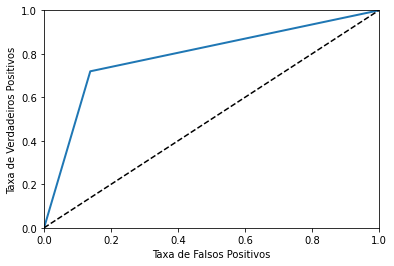

In [9]:
logisticRegr = LogisticRegression()

logisticRegr.fit(X_train, y_train)

y_pred = logisticRegr.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
cmLR = confusion_matrix(y_test, y_pred)

##Indicadores

pLR = precision_score(y_test,y_pred)
rLR = recall_score(y_test,y_pred)
F1LR = f1_score(y_test, y_pred)
print("Precisão:", pLR)
print("Recall:", rLR)
print("F1Score:", F1LR)
fprLR, tprLR, threshold_LR = roc_curve(y_test,y_pred)
plot_roc_curve(fprLR,tprLR)
aucLR = roc_auc_score(y_test,y_pred)
print("AUC Score:",aucLR)


## Results
**\>7** 

|          |     0       |     1      |
|----------|-------------|------------|
|     0    |     4199    |     215    |
|     1    |     869     |     422    |

Accuracy: 0.8099912357581069

**\>=7** 

|          |     0       |     1      |
|----------|-------------|------------|
|     0    |     3011    |     482    |
|     1    |     620     |     1592   |

Accuracy: 0.8068361086765995

Precisão: 0.7675988428158148

Recall: 0.7197106690777577

F1Score: 0.7428838077461501

AUC Score: 0.7908602014154893

Para Regressão Logística ele acertou 72% dos 1's e teve uma precisão de 76%, ou seja 24% de Falsos Negativos (Onde era para ser 1, ele dectou como 0). A curva ROC se mostrou próxima da Linha, mas mais distante que o SVM. 

## KNN

Accuracy: 0.7985977212971078
Precisão: 0.7324005247048535
Recall: 0.7572332730560579
F1Score: 0.7446099133140698
AUC Score: 0.7910128575414844


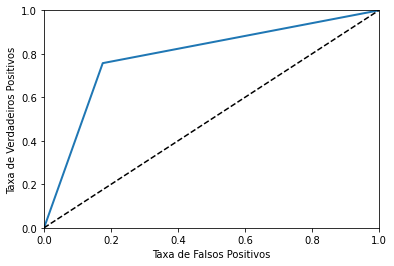

In [10]:
from sklearn.neighbors import KNeighborsClassifier

Knn_Class = KNeighborsClassifier()

Knn_Class.fit(X_train, y_train)
y_pred = Knn_Class.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
cmKNN = confusion_matrix(y_test, y_pred)

pKNN = precision_score(y_test,y_pred)
rKNN = recall_score(y_test,y_pred)
F1KNN = f1_score(y_test, y_pred)
print("Precisão:", pKNN)
print("Recall:", rKNN)
print("F1Score:", F1KNN)
fprKNN, tprKNN, threshold_KNN = roc_curve(y_test,y_pred)
plot_roc_curve(fprKNN,tprKNN)

aucKNN = roc_auc_score(y_test,y_pred)

print("AUC Score:",aucKNN)

## Results

**\>7** 

|          |     0       |     1      |
|----------|-------------|------------|
|     0    |     4020    |     394    |
|     1    |     573     |     718    |

Accuracy: 0.8304995617879053

**\>=7** 

|          |     0       |     1      |
|----------|-------------|------------|
|     0    |     2881    |     612    |
|     1    |     537     |     1675    |

Accuracy: 0.7985977212971078

Precisão: 0.7324005247048535

Recall: 0.7572332730560579

F1Score: 0.7446099133140698

AUC Score: 0.7910128575414844

Novamente existem valores muito próximos entre precisão e Recall, tudo em torno de 75%. Ou seja, ao mesmo tempo que a técnica acerta 75% dos positivos totais, ele também tem uma acurácia das previsões positivas de 75%. Equilíbrio entre as partes. 

# Método Ensemble e Bagging

Um grupo de preditores é chamado de "Ensemble". Em Bagging o conjunto de treinamento é dividio em grupos, e utilizados classificadores separados para o treinamento. 

![](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1542651255/image_2_pu8tu6.png)

A Random Forest é um metodo de Bagging da Árvore de Decisão


## Função RandomForestClassifier

```
class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
```

* n_estimators: Default igual a 100 e representa o número máximo de estimadores;
* criteerion: Função que mede a qualidade do Split;
* max_leaf_nodes: redução realtiva de impureza, é a quandiade máxima de "folhas" ESTUDAR ÁRVORE DE DECISÃO


> Reducing max_depth will regularize the model and thus reduce the risk of overfitting.

A regulagem das árvores podem ser realizadas por meio dos parâmetros:

* min_samples_split: O número mínimo de amostras que um nó pode ter antes de dividir;
* min_samples_leaf: O número mínimo de amostras que uma folha pode ter; 
* min_wight_fraction_leaf: mesmo que samples_leaf, mas aqui é trabalhado em proporção;
* max_features: Número máximo de features que pode ser avaliada em cada nó; 

>Increasing min_* hyperparameters or reducing max_* hyperparameters will regularize the model.

# Random Forest


In [22]:
from sklearn.ensemble import RandomForestClassifier

from bayes_opt import BayesianOptimization

from sklearn.model_selection import cross_val_score

In [6]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {"bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
        "max_depth": Integer(6, 12, 24, 48), # values of max_depth are integers from 6 to 20
        "min_samples_leaf": Integer(2, 4, 8, 16),
        "min_samples_split": Integer(2, 4, 8, 16),
        "n_estimators": Integer(200, 400, 600, 800)
    }




In [23]:
def rfc_optimization(cv_splits):
    def function(n_estimators, max_depth, min_samples_split):
        return cross_val_score(
               RandomForestClassifier(
                   n_estimators=int(max(n_estimators,0)),                                                               
                   max_depth=int(max(max_depth,1)),
                   min_samples_split=int(max(min_samples_split,2)), 
                   n_jobs=-1, 
                   random_state=42,   
                   class_weight="balanced"),  
               X=X_train, 
               y=y_train, 
               cv=cv_splits,
               scoring="roc_auc",
               n_jobs=-1).mean()

    parameters = {"n_estimators": (10, 1000),
                  "max_depth": (1, 150),
                  "min_samples_split": (2, 10)}
    
    return function, parameters


In [ ]:
bayesian_optimization()

In [21]:


forest_clf = RandomForestClassifier()

forestOptB = BayesianOptimization(forest_clf, {"max_depth": (6, 12), # values of max_depth are integers from 6 to 20
        "min_samples_leaf": (2, 8),
        "min_samples_split": (2, 8),
        "n_estimators": (600, 800)
    })

forestOptB.maximize(n_iter=15, init_points=2)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------


TypeError: 'RandomForestClassifier' object is not callable

In [14]:
forest_clf = RandomForestClassifier()

forest_bayes_search = BayesSearchCV(forest_clf, search_space, n_iter=10, # specify how many iterations
                                    scoring="roc_auc", n_jobs=-1)

forest_bayes_search.fit(X_train, y_train) 

BayesSearchCV(estimator=RandomForestClassifier(), n_iter=10, n_jobs=-1,
              scoring='roc_auc',
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'max_depth': Integer(low=6, high=12, prior='24', transform='identity'),
                             'min_samples_leaf': Integer(low=2, high=4, prior='8', transform='identity'),
                             'min_samples_split': Integer(low=2, high=4, prior='8', transform='identity'),
                             'n_estimators': Integer(low=200, high=400, prior='600', transform='identity')})

In [9]:
forest_bayes_search.best_score_

forest_bayes_search.best_estimator_



RandomForestClassifier(bootstrap=False, max_depth=8, min_samples_leaf=5,
                       min_samples_split=5, n_estimators=382)

Accuracy: 0.8581945661700263
Precisão: 0.8307402168788307
Recall: 0.7965641952983725
F1Score: 0.8132933302561737
AUC Score: 0.8468936063809355


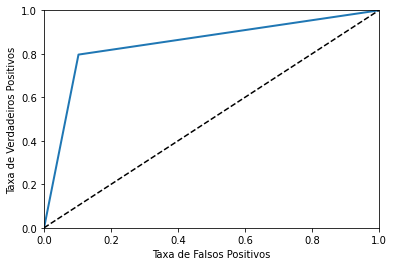

In [15]:
Rand_Forest_Class = forest_bayes_search.best_estimator_

y_pred = Rand_Forest_Class.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
cmRF = confusion_matrix(y_test, y_pred)


pRF = precision_score(y_test,y_pred)
rRF = recall_score(y_test,y_pred)
F1RF = f1_score(y_test, y_pred)
print("Precisão:", pRF)
print("Recall:", rRF)
print("F1Score:", F1RF)
fprRF, tprRF, threshold_RF = roc_curve(y_test,y_pred)
plot_roc_curve(fprRF,tprRF)
aucRF = roc_auc_score(y_test,y_pred)
print("AUC Score:",aucRF)

In [11]:
## Código - Parâmetros Ajustados
estimadores = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
resultados_estimadores = pd.DataFrame(columns=["n_estimadores", "Acc", "Precis", "Recall", "F1", "AUC"])


for index, i in enumerate(estimadores):
    Rand_Forest_Class = RandomForestClassifier(n_estimators=i, n_jobs=-1)
    Rand_Forest_Class.fit(X_train, y_train)
    y_pred = Rand_Forest_Class.predict(X_test)
    AccRF = metrics.accuracy_score(y_test, y_pred)
    cmRF = confusion_matrix(y_test, y_pred)
    pRF = precision_score(y_test,y_pred)
    rRF = recall_score(y_test,y_pred)
    F1RF = f1_score(y_test, y_pred)
    fprRF, tprRF, threshold_RF = roc_curve(y_test,y_pred)
    aucRF = roc_auc_score(y_test,y_pred)
    resultados_estimadores.loc[index] = [i, AccRF, pRF, rRF, F1RF, aucRF]
    



In [12]:
print(resultados_estimadores)

   n_estimadores       Acc    Precis    Recall        F1       AUC
0          100.0  0.853111  0.828708  0.783002  0.805207  0.840256
1          200.0  0.857143  0.832778  0.790235  0.810949  0.844874
2          300.0  0.855741  0.828991  0.791139  0.809623  0.843895
3          400.0  0.857143  0.832461  0.790687  0.811036  0.844957
4          500.0  0.856792  0.830725  0.792043  0.810923  0.844919
5          600.0  0.857844  0.833413  0.791591  0.811964  0.845695
6          700.0  0.858370  0.833333  0.793400  0.812876  0.846456
7          800.0  0.857318  0.831909  0.792043  0.811487  0.845349
8          900.0  0.858370  0.833017  0.793852  0.812963  0.846539
9         1000.0  0.857844  0.831833  0.793852  0.812399  0.846110


In [8]:
## Código - Parâmetros Ajustados - Max Depth
max_depth_list = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45]
resultados_max_depth = pd.DataFrame(columns=["max_depth", "Acc", "Precis", "Recall", "F1", "AUC"])


for index, i in enumerate(max_depth_list):
    Rand_Forest_Class = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth= i)
    Rand_Forest_Class.fit(X_train, y_train)
    y_pred = Rand_Forest_Class.predict(X_test)
    AccRF = metrics.accuracy_score(y_test, y_pred)
    cmRF = confusion_matrix(y_test, y_pred)
    pRF = precision_score(y_test,y_pred)
    rRF = recall_score(y_test,y_pred)
    F1RF = f1_score(y_test, y_pred)
    fprRF, tprRF, threshold_RF = roc_curve(y_test,y_pred)
    aucRF = roc_auc_score(y_test,y_pred)
    resultados_max_depth.loc[index] = [i, AccRF, pRF, rRF, F1RF, aucRF]

print("n_estimadores = 100 \n")

print(resultados_max_depth)



n_estimadores = 100 

   max_depth       Acc    Precis    Recall        F1       AUC
0        1.0  0.849080  0.860267  0.729204  0.789332  0.827099
1        5.0  0.859246  0.837243  0.790687  0.813299  0.846675
2       10.0  0.854864  0.825800  0.792948  0.809041  0.843511
3       15.0  0.857669  0.829257  0.797016  0.812817  0.846547
4       20.0  0.854689  0.827260  0.790235  0.808324  0.842870
5       25.0  0.856617  0.832856  0.788427  0.810033  0.844113
6       30.0  0.857493  0.832304  0.792043  0.811675  0.845492
7       35.0  0.855565  0.831107  0.787523  0.808728  0.843089
8       40.0  0.857844  0.833096  0.792043  0.812051  0.845778
9       45.0  0.856617  0.836715  0.783002  0.808968  0.843118


In [10]:
## Código - Parâmetros Ajustados - Max Depth
max_leafnodes_list = [2, 4, 8, 10, 12, 14, 16, 18, 20, 22, 30, 40, 50]
resultados_max_nodes = pd.DataFrame(columns=["leaf_nodes", "Acc", "Precis", "Recall", "F1", "AUC"])


for index, i in enumerate(max_leafnodes_list):
    Rand_Forest_Class = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_leaf_nodes= i)
    Rand_Forest_Class.fit(X_train, y_train)
    y_pred = Rand_Forest_Class.predict(X_test)
    AccRF = metrics.accuracy_score(y_test, y_pred)
    cmRF = confusion_matrix(y_test, y_pred)
    pRF = precision_score(y_test,y_pred)
    rRF = recall_score(y_test,y_pred)
    F1RF = f1_score(y_test, y_pred)
    fprRF, tprRF, threshold_RF = roc_curve(y_test,y_pred)
    aucRF = roc_auc_score(y_test,y_pred)
    resultados_max_nodes.loc[index] = [i, AccRF, pRF, rRF, F1RF, aucRF]

print("n_estimadores = 100 \n")

print(resultados_max_nodes)


n_estimadores = 100 

    leaf_nodes       Acc    Precis    Recall        F1       AUC
0          2.0  0.850482  0.860477  0.733273  0.791799  0.828990
1          4.0  0.850307  0.856993  0.736890  0.792416  0.829510
2          8.0  0.854514  0.840730  0.770796  0.804245  0.839163
3         10.0  0.855565  0.840864  0.773960  0.806026  0.840602
4         12.0  0.857318  0.840312  0.780289  0.809189  0.843194
5         14.0  0.855565  0.835590  0.781193  0.807477  0.841928
6         16.0  0.856792  0.840078  0.778933  0.808351  0.842516
7         18.0  0.855916  0.839355  0.777125  0.807042  0.841468
8         20.0  0.855565  0.838537  0.777125  0.806664  0.841182
9         22.0  0.858545  0.841517  0.782550  0.810963  0.844610
10        30.0  0.858195  0.839381  0.784358  0.810937  0.844655
11        40.0  0.859246  0.842489  0.783454  0.811900  0.845348
12        50.0  0.856442  0.832458  0.788427  0.809844  0.843970


In [12]:
## Código - Parâmetros Ajustados - Min Samples
min_samples_list = [2, 4, 8, 10, 12, 14, 16, 18, 20, 22, 30, 40, 50]
resultados_min_samples = pd.DataFrame(columns=["min_samples", "Acc", "Precis", "Recall", "F1", "AUC"])


for index, i in enumerate(min_samples_list):
    Rand_Forest_Class = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_samples_leaf= i)
    Rand_Forest_Class.fit(X_train, y_train)
    y_pred = Rand_Forest_Class.predict(X_test)
    AccRF = metrics.accuracy_score(y_test, y_pred)
    cmRF = confusion_matrix(y_test, y_pred)
    pRF = precision_score(y_test,y_pred)
    rRF = recall_score(y_test,y_pred)
    F1RF = f1_score(y_test, y_pred)
    fprRF, tprRF, threshold_RF = roc_curve(y_test,y_pred)
    aucRF = roc_auc_score(y_test,y_pred)
    resultados_min_samples.loc[index] = [i, AccRF, pRF, rRF, F1RF, aucRF]

print("n_estimadores = 100 \n")

print(resultados_min_samples)


n_estimadores = 100 

    min_samples       Acc    Precis    Recall        F1       AUC
0           2.0  0.856792  0.830412  0.792495  0.811011  0.845002
1           4.0  0.857669  0.831126  0.794304  0.812298  0.846050
2           8.0  0.856091  0.830404  0.790235  0.809822  0.844015
3          10.0  0.859071  0.833018  0.796112  0.814147  0.847526
4          12.0  0.858896  0.832310  0.796564  0.814045  0.847466
5          14.0  0.856617  0.830019  0.792495  0.810823  0.844859
6          16.0  0.859597  0.836433  0.792948  0.814110  0.847376
7          18.0  0.857143  0.830886  0.792948  0.811474  0.845372
8          20.0  0.856968  0.830492  0.792948  0.811286  0.845228
9          22.0  0.857669  0.833651  0.790687  0.811601  0.845387
10         30.0  0.857143  0.833731  0.788879  0.810685  0.844626
11         40.0  0.856968  0.831120  0.792043  0.811111  0.845063
12         50.0  0.856968  0.834291  0.787523  0.810233  0.844234


Accuracy: 0.8581945661700263
Precisão: 0.832937826293308
Recall: 0.7933996383363472
F1Score: 0.812688122250521
AUC Score: 0.8463133319079389


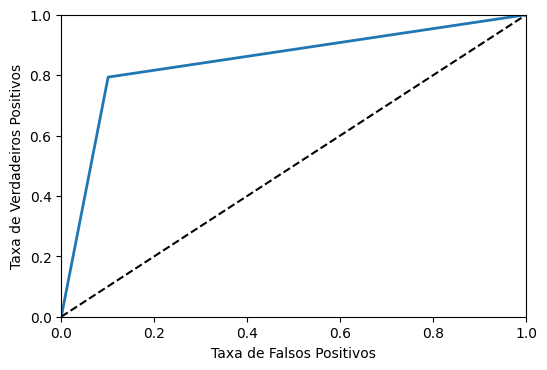

In [53]:
## Código Inicial - Parâmetros Default

Rand_Forest_Class = RandomForestClassifier()

Rand_Forest_Class.fit(X_train, y_train)

y_pred = Rand_Forest_Class.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
cmRF = confusion_matrix(y_test, y_pred)


pRF = precision_score(y_test,y_pred)
rRF = recall_score(y_test,y_pred)
F1RF = f1_score(y_test, y_pred)
print("Precisão:", pRF)
print("Recall:", rRF)
print("F1Score:", F1RF)
fprRF, tprRF, threshold_RF = roc_curve(y_test,y_pred)
plot_roc_curve(fprRF,tprRF)
aucRF = roc_auc_score(y_test,y_pred)
print("AUC Score:",aucRF)

In [9]:
## Importância dos Parâmetros
features = X_train.columns
feature_dict = dict()

for name, score in zip(features, Rand_Forest_Class.feature_importances_):
    feature_dict[name] = score
    print(name, score)

OPERADORA 0.01519283990766028
ESTADO 0.027097297708722344
ANO_BASE 0.011879207114724495
Q5 0.00490077634094653
Q7 0.03087522744419723
Q8 0.00610230968883058
B1_1 0.06380206919187986
B1_2 0.13820599211736848
C1_1 0.08539921704012678
C1_2 0.1008162488808531
C1_3 0.1466592621224701
D1_1 0.028967921713405276
D1_2 0.02316714200156242
A1_2 0.005674374536424691
A1_3 0.004298537932308901
A2_1 0.019986976811898708
A2_2 0.02993562541834148
A2_3 0.018045452989855777
A3 0.023503935970584134
E2 0.03124609081990927
E3 0.00579301749571393
E5 0.005403114196148945
E8 0.06319510272392892
F1 0.00445784708412152
F4_1 0.01944041065096065
F4_2 0.0219232846929379
F4_3 0.026530202064156235
H1 0.013191872755420995
H2 0.024308642584540473


## Análise de Pareto

Para o Random Forest será realizada uma análise de Pareto e selecionar apenas as colunas que representam predominância na classificação.

In [11]:
cum_sum = list()

sum = 0
for i in features:
    sum = sum + feature_dict[i]
    cum_sum.append(sum)

print(cum_sum)





[0.01519283990766028, 0.042290137616382624, 0.05416934473110712, 0.05907012107205365, 0.08994534851625088, 0.09604765820508146, 0.15984972739696132, 0.2980557195143298, 0.38345493655445656, 0.48427118543530967, 0.6309304475577797, 0.659898369271185, 0.6830655112727474, 0.6887398858091721, 0.6930384237414811, 0.7130254005533798, 0.7429610259717213, 0.7610064789615771, 0.7845104149321612, 0.8157565057520705, 0.8215495232477844, 0.8269526374439333, 0.8901477401678622, 0.8946055872519838, 0.9140459979029445, 0.9359692825958824, 0.9624994846600387, 0.9756913574154596, 1.0000000000000002]


In [22]:
print(feature_dict.keys())

feature_dict =  dict(sorted(feature_dict.items(), key=lambda item: item[1], reverse=True))

print(feature_dict)

dict_keys(['C1_3', 'B1_2', 'C1_2', 'C1_1', 'B1_1', 'E8', 'E2', 'Q7', 'A2_2', 'D1_1', 'ESTADO', 'F4_3', 'H2', 'A3', 'D1_2', 'F4_2', 'A2_1', 'F4_1', 'A2_3', 'OPERADORA', 'H1', 'ANO_BASE', 'Q8', 'E3', 'A1_2', 'E5', 'Q5', 'F1', 'A1_3'])
{'C1_3': 0.1466592621224701, 'B1_2': 0.13820599211736848, 'C1_2': 0.1008162488808531, 'C1_1': 0.08539921704012678, 'B1_1': 0.06380206919187986, 'E8': 0.06319510272392892, 'E2': 0.03124609081990927, 'Q7': 0.03087522744419723, 'A2_2': 0.02993562541834148, 'D1_1': 0.028967921713405276, 'ESTADO': 0.027097297708722344, 'F4_3': 0.026530202064156235, 'H2': 0.024308642584540473, 'A3': 0.023503935970584134, 'D1_2': 0.02316714200156242, 'F4_2': 0.0219232846929379, 'A2_1': 0.019986976811898708, 'F4_1': 0.01944041065096065, 'A2_3': 0.018045452989855777, 'OPERADORA': 0.01519283990766028, 'H1': 0.013191872755420995, 'ANO_BASE': 0.011879207114724495, 'Q8': 0.00610230968883058, 'E3': 0.00579301749571393, 'A1_2': 0.005674374536424691, 'E5': 0.005403114196148945, 'Q5': 0.004

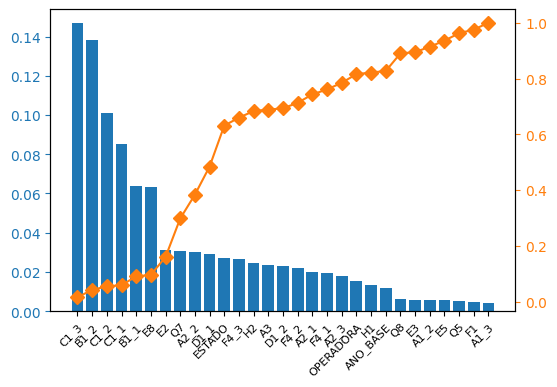

In [44]:
fig, ax = plt.subplots()
ax.bar(feature_dict.keys(), feature_dict.values(), color="C0")
ax2 = ax.twinx()
ax2.plot(feature_dict.keys(), cum_sum, color="C1", marker="D", ms=7)
plt.rcParams["figure.dpi"] = 100
ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", size = 8)
plt.show()

Com base na relação de Pareto encontrada, os parâmetros C1_3, B1_2, C1_2, C1_1, B1_1, E8 e E2 são os principais atributos. 

In [50]:
most_rlv_features_dataset = Data_Filter.copy()

params = most_rlv_features_dataset.columns

for i in params:
    if i != "C1_3" and i != "B1_2" and i != "C1_2" and i != "C1_1" and i != "B1_1" and i != "E8" and i != "E2" and i != "J1":
        most_rlv_features_dataset.drop(i, inplace= True, axis = 1)


Dados_Y_N = Data_Filter["J1"].copy()
Dados_X_N = most_rlv_features_dataset.copy()
Dados_X_N.drop("J1", inplace= True, axis = 1)

X_train_N, X_test_N, y_train_N, y_test_N = train_test_split(Dados_X_N, Dados_Y_N, test_size=0.3,random_state=109) # 70% training and 30% test



Accuracy: 0.8476774758983348
Precisão: 0.8199142448785136
Recall: 0.7780289330922242
F1Score: 0.7984226397587567
AUC Score: 0.8349062501132465


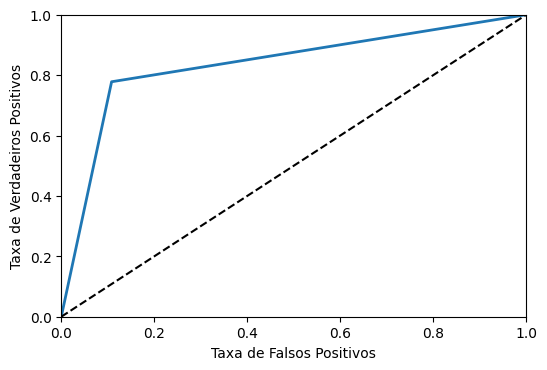

In [52]:
## Random Forest com apenas Parâmetros selecionados


Rand_Forest_Class = RandomForestClassifier()

Rand_Forest_Class.fit(X_train_N, y_train_N)

y_pred_N = Rand_Forest_Class.predict(X_test_N)

print("Accuracy:",metrics.accuracy_score(y_test_N, y_pred_N))
cmRF = confusion_matrix(y_test_N, y_pred_N)


pRF = precision_score(y_test_N,y_pred_N)
rRF = recall_score(y_test_N,y_pred_N)
F1RF = f1_score(y_test_N, y_pred_N)
print("Precisão:", pRF)
print("Recall:", rRF)
print("F1Score:", F1RF)
fprRF, tprRF, threshold_RF = roc_curve(y_test_N,y_pred_N)
plot_roc_curve(fprRF,tprRF)
aucRF = roc_auc_score(y_test_N,y_pred_N)
print("AUC Score:",aucRF)

## Results
**\>7**

|          |     0       |     1      |
|----------|-------------|------------|
|     0    |     4174    |     240    |
|     1    |     527     |     864    |

Accuracy: 0.8830850131463628

**\>=7** 

|          |     0       |     1      |
|----------|-------------|------------|
|     0    |     3140    |     353    |
|     1    |     468     |     1744   |

Accuracy: 0.856091148115688

Precisão: 0.8316642823080591

Recall: 0.7884267631103075

F1Score: 0.809468554188907

AUC Score: 0.8444071687679154

Aqui existe uma precisão maior que o Recall, significa que existem vários Falsos Negativos, pois muitos 1's não são detectados, mas muito 0 foi detectado como 1 ou Falsos Positivos. A curva ROC Distancia um pouco mais. 

Comparação Após o Pareto

| Técnica             | Acurácia           | Precisão           | Revocação          | F1 Score           | ROC AUC            |
|---------------------|--------------------|--------------------|--------------------|--------------------|--------------------|
| Antes                 | 85609 | 0.83166 | 0.78842 |  0.8094|0.84440 |
| Depois | 0.8476 | 0.8199 | 0.778 | 0.7984 | 0.8349 |




Text(0, 0.5, 'Taxa de Verdadeiros Positivos')

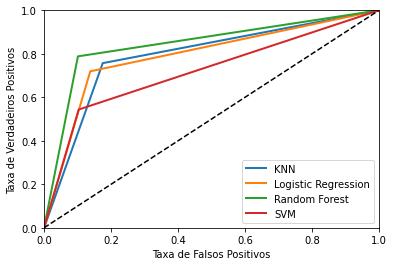

In [17]:
plt.plot(fprKNN, tprKNN, linewidth = 2, label = "KNN")
plt.plot(fprLR, tprLR, linewidth = 2, label = "Logistic Regression")
plt.plot(fprRF, tprRF, linewidth = 2, label = "Random Forest")
plt.plot(fprSVM, tprSVM, linewidth = 2, label = "SVM")
plt.plot([0,1], [0,1], 'k--')
plt.axis([0,1,0,1])
plt.legend()
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")

| Técnica             | Acurácia           | Precisão           | Revocação          | F1 Score           | ROC AUC            |
|---------------------|--------------------|--------------------|--------------------|--------------------|--------------------|
| SVM                 | 0.7598 | 0.7691 | 0.5438 | 0.6371| 0.7202 |
| Logistic Regression | 0.8068 | 0.7675 | 0.7197 | 0.7428 | 0.7908 |
| Random Forest       | 0.8560  | 0.8316 | 0.7884 | 0.8094  | 0.8444 |
| KNN                 | 0.7985 | 0.7324 | 0.7572 | 0.7446 | 0.7910 |